## Завдання 1

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier

## Завантажити датасет

In [3]:
mushrooms = pd.read_csv("mushroom_cleaned.csv")


## Вивести перші 5 рядків.

In [4]:
mushrooms.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


## Вивести розмір датасету, наявність пропущених даних, типи даних.



In [5]:
mushrooms.shape


(54035, 9)

In [6]:
mushrooms.isnull().sum()


cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

In [7]:
mushrooms.dtypes


cap-diameter         int64
cap-shape            int64
gill-attachment      int64
gill-color           int64
stem-height        float64
stem-width           int64
stem-color           int64
season             float64
class                int64
dtype: object

## Вивести матрицю кореляції

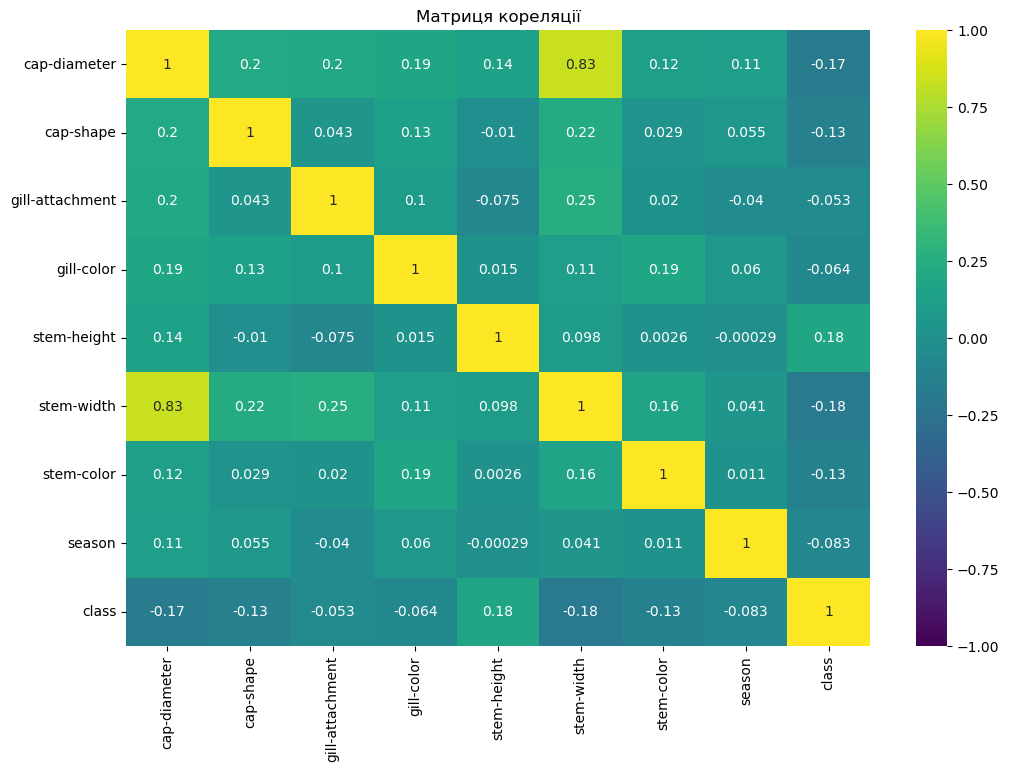

In [9]:
corr_matrix = mushrooms.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, center=0)
plt.title('Матриця кореляції')
plt.show()

## Вивести кореляцію з цільовою функцією

In [10]:
corr_func = mushrooms.corr()['class'].sort_values(ascending=False)
print(corr_func)

class              1.000000
stem-height        0.183354
gill-attachment   -0.052541
gill-color        -0.063947
season            -0.082919
stem-color        -0.128339
cap-shape         -0.133338
cap-diameter      -0.165676
stem-width        -0.182856
Name: class, dtype: float64


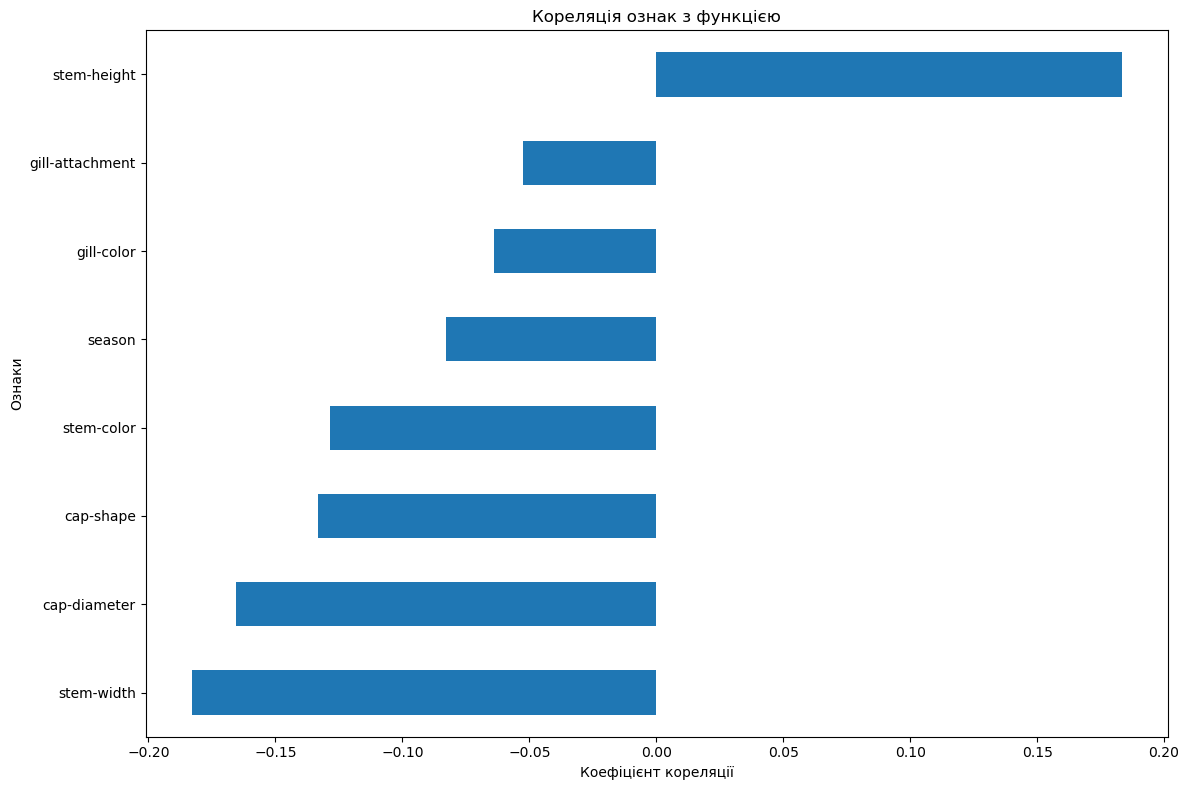

In [14]:
sorted_correlations = corr_func.drop('class').sort_values(ascending=True)

plt.figure(figsize=(12, 8))
sorted_correlations.plot(kind='barh')
plt.title('Кореляція ознак з функцією')
plt.xlabel('Коефіцієнт кореляції')
plt.ylabel('Ознаки')
plt.tight_layout()
plt.show()

## Побудувати дві моделі класифікації на вибір

## Масштабуємо

In [15]:
x = mushrooms.drop('class', axis=1)
y = mushrooms['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Random Forest

In [23]:
param_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 35],
              'max_features': ["log2", "sqrt"],
             'criterion': ["gini", "entropy"]}
rf = RandomForestClassifier(random_state = 42)
gs_rf = GridSearchCV(rf, param_grid, cv=5)
gs_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 35],
                         'max_features': ['log2', 'sqrt']})

In [25]:
print("Найкращі параметри", gs_rf.best_params_)
print("Найкраща оцінка cross test", gs_rf.best_score_)

Найкращі параметри {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2'}
Найкраща оцінка cross test 0.9894141946780726


## Тестова вибірка

In [26]:
best_model = gs_rf.best_estimator_
test_score = best_model.score(x_test, y_test)
print("Оцінка на тестовому наборі:", test_score)

Оцінка на тестовому наборі: 0.9903027611222148


## Логістична регресія

In [49]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
lr = LogisticRegression(random_state=0)
gs = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [50]:
print("Найкращі параметри:", gs.best_params_)
print("Найкраща оцінка cross test", gs.best_score_)

Найкращі параметри: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Найкраща оцінка cross test 0.6352464576014933


## Перевірка на тестовій вибірці

In [51]:
best_model = gs.best_estimator_
test_score = best_model.score(x_test, y_test)
print("Оцінка на тестовій вибірці", test_score)

Оцінка на тестовій вибірці 0.6348360352357687


## Random Forest показує значно кращі результати ніж логістична регресія

## Вивести матрицю плутанини та класифікаційний звіт

In [53]:
y_pred = gs_rf.best_estimator_.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nМатриця плутанини")
print(conf_matrix)
print("\nКласифікаційний звіт")
print(class_report)

Accuracy: 0.9903027611222148

Матриця плутанини
[[6060   70]
 [  61 7318]]

Класифікаційний звіт
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6130
           1       0.99      0.99      0.99      7379

    accuracy                           0.99     13509
   macro avg       0.99      0.99      0.99     13509
weighted avg       0.99      0.99      0.99     13509



## Методом Ліктя та методом Силуетів визначити оптимальну кількість кластерів

In [54]:
wcss_2dim = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
    kmeans.fit(x_train)
    wcss_2dim.append(kmeans.inertia_)

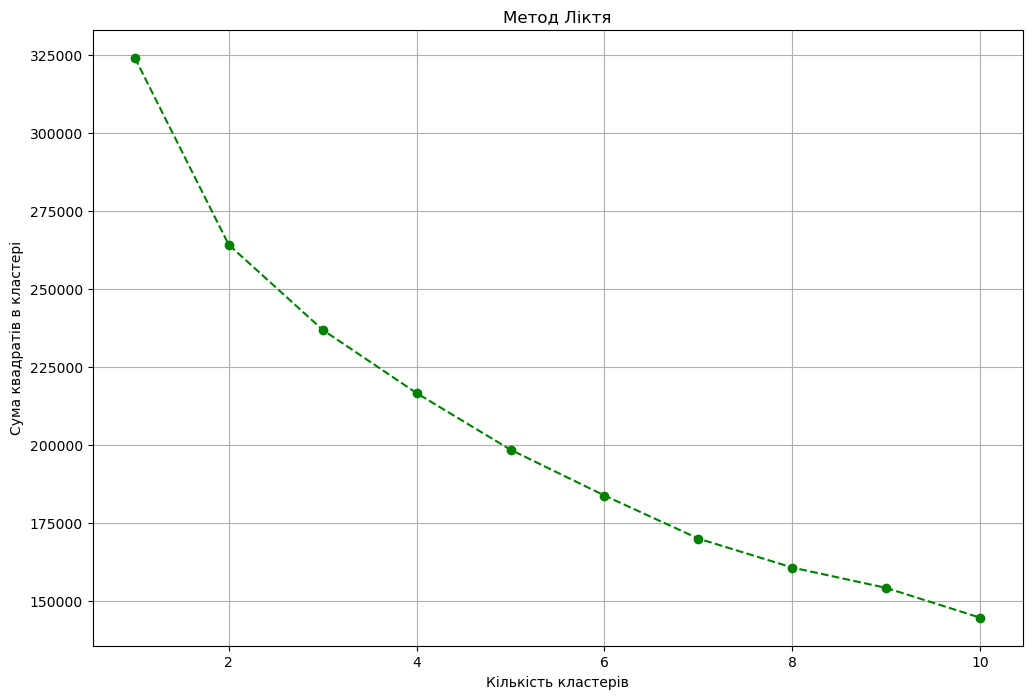

In [88]:
plt.figure(figsize=(12,8))
plt.plot(range(1, 11), wcss_2dim, marker='o', linestyle='--',color='green')
plt.title('Метод Ліктя')
plt.xlabel('Кількість кластерів')
plt.ylabel('Сума квадратів в кластері')
plt.grid(True)
plt.show()

## За методом Силуетів

In [56]:
silhouette_q = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(x_train)
    silhouette_avg = silhouette_score(x_train, cluster_labels)
    silhouette_q.append(silhouette_avg)

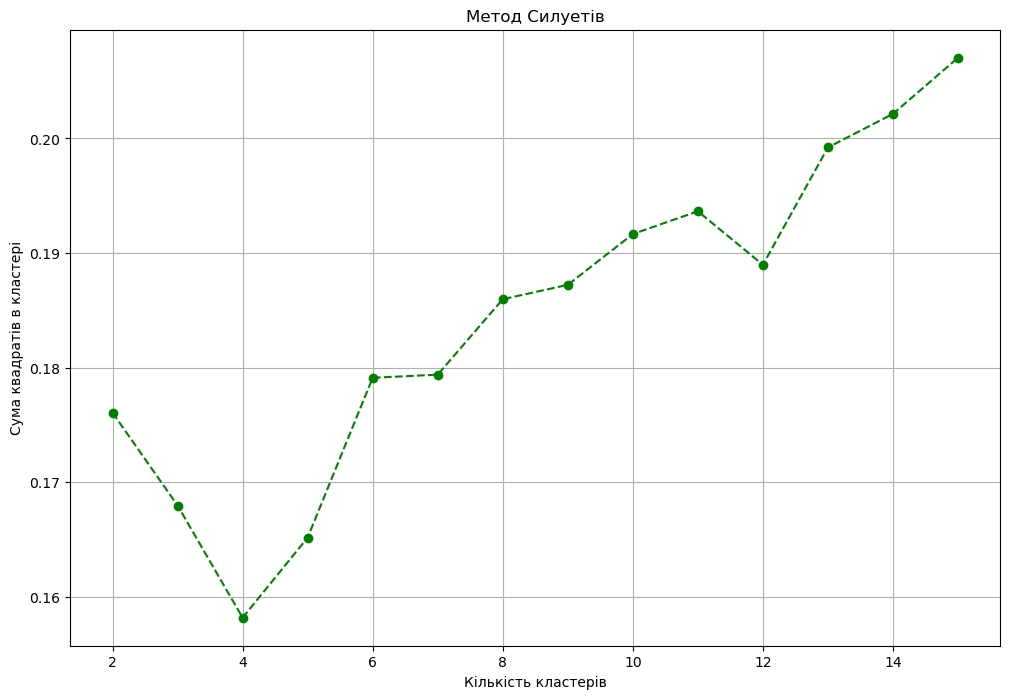

In [80]:
plt.figure(figsize=(12,8))
plt.plot(range(2, 18), silhouette_q, marker='o', linestyle='--', color='green')
plt.title('Метод Силуетів')
plt.xlabel('Кількість кластерів')
plt.ylabel('Сума квадратів в кластері')
plt.grid(True)
plt.show()

### Оптимальна кількість кластерів за методом Силуетів = 14

## Візуалізація кластерів

C:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


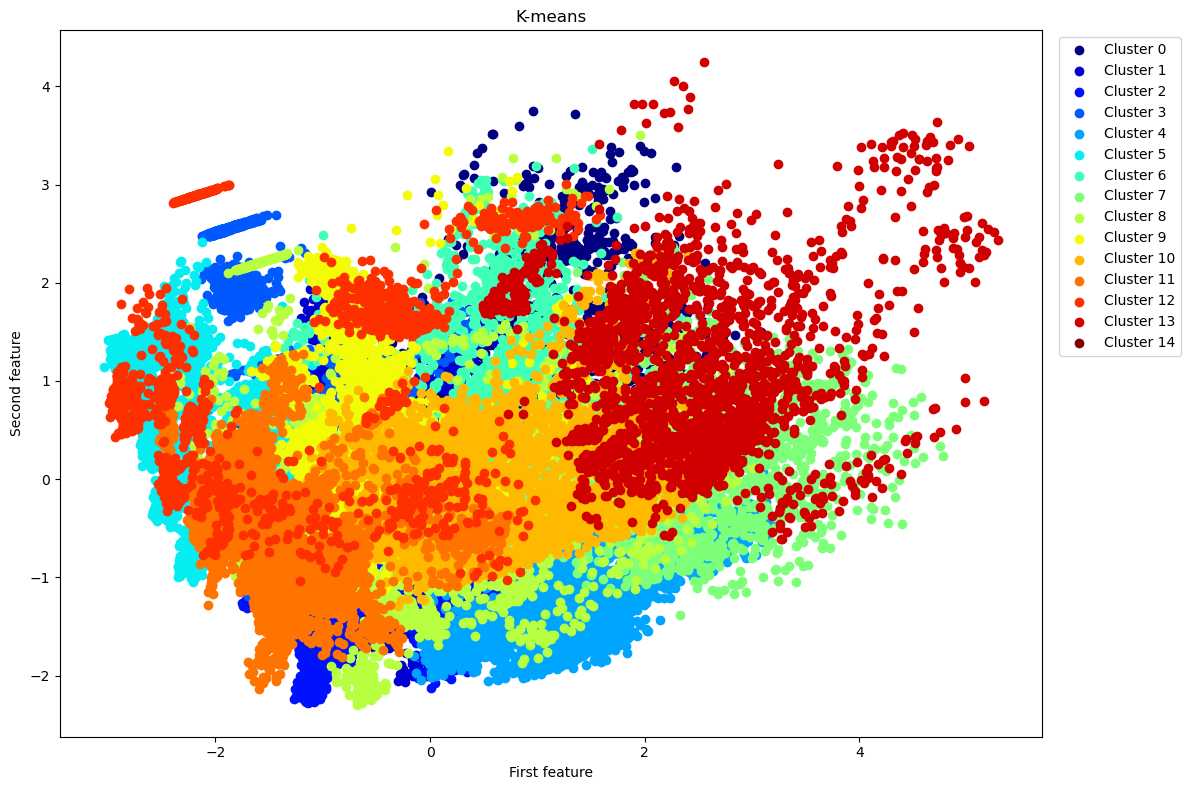

In [89]:
kmeans = KMeans(n_clusters=14, random_state=42)
cluster_labels = kmeans.fit_predict(x_train)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train)
colors = plt.cm.jet(np.linspace(0, 1, 15))
plt.figure(figsize=(12, 8))
for i in range(15):
    cluster_points = x_pca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[i]], label=f'Cluster {i}')
plt.title('K-means')
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

## DBSCAN

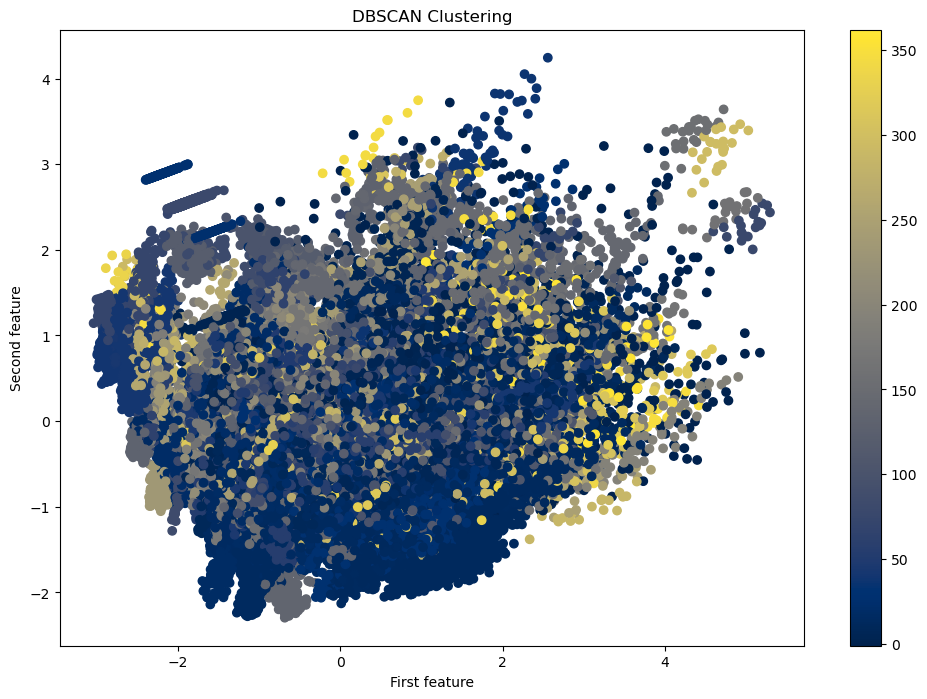

Кількість кластерів 363


In [87]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  
dbscan_color = dbscan.fit_predict(x_train)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=dbscan_color, cmap='cividis')
plt.title('DBSCAN Clustering')
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.colorbar(scatter)
plt.show()
num_clusters = len(set(dbscan_color)) - (1 if -1 in dbscan_color else 0)
print(f"Кількість кластерів {num_clusters}")

## Висновки
## Було знайдено, що переважна кількість ознак не кореляює з функцією, слабка негативна кореляція.
## Модель Random Forest виявилася найкращою у порівнянні з Logistic Regression, яка має низьку точність. За Методом Ліктя не вдалося знайти оптимальну кількість кластерів. За Методом Силуету виявлено, що оптимальна кількість кластерів = 14. За алгоритмом DBSCAN виявлено 363 кластерів. 